<a href="https://colab.research.google.com/github/Teasotea/strategic_stability/blob/main/StratStabTask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries & Load Data

In [3]:
!pip install bertopic
!pip install bertopic[visualization]
!pip install bertopic[spacy]
!pip install umap-learn
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 1.9 MB/s 
     |████████████████████████████████| 5.2 MB 8.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 88 kB 5.6 MB/s 
     |████████████████████████████████| 79 kB 4.1 MB/s 
     |████████████████████████████████| 4.2 MB 19.5 MB/s 
     |████████████████████████████████| 1.2 MB 40.8 MB/s 
     |████████████████████████████████| 84 kB 2.5 MB/s 
     |████████████████████████████████| 636 kB 39.6 MB/s 
     |████████████████████████████████| 6.6 MB 45.1 MB/s 
     |████████████████████████████████| 1.1 MB 23.8 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2342155 sha256=a9453bcd86e0840cdb03d59add33e5f6b1df50f13663d4aa3f6993426093c4ba
  Stored in directory: /root/.cache/pi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pathlib import Path
from google.colab import drive

drive.mount('/content/gdrive')

GDRIVE = '/content/gdrive/MyDrive/stratStab'
WORKDIR = GDRIVE

Mounted at /content/gdrive


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string, collections
import os  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 

import pickle
# import pyLDAvis.sklearn
# from collections import Counter
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator

import re
from tqdm.auto import tqdm

%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

In [146]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from umap import UMAP

from nltk.util import ngrams

In [230]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [13]:
data = pd.read_csv('strategic_data.csv')

In [14]:
data.head()

,name,fulltext,database,source,date,issue
0,"США НЕ ВКЛЮЧИЛИ В ПЕРЕГОВОРЫ РФ ПО СТРАТЕГИЧЕСКОЙ СТАБИЛЬНОСТИ ТЕМУ МИЛИТАРИЗАЦИИ КОСМОСА, МОСКВ...","США НЕ ВКЛЮЧИЛИ В ПЕРЕГОВОРЫ РФ ПО СТРАТЕГИЧЕСКОЙ СТАБИЛЬНОСТИ ТЕМУ МИЛИТАРИЗАЦИИ КОСМОСА, МОСКВ...",Федеральные информагентства,РИА Новости. Все Новости,2020,14 октября
1,"США НЕ ВКЛЮЧИЛИ В ПЕРЕГОВОРЫ РФ ПО СТРАТЕГИЧЕСКОЙ СТАБИЛЬНОСТИ ТЕМУ МИЛИТАРИЗАЦИИ КОСМОСА, МОСКВ...","США НЕ ВКЛЮЧИЛИ В ПЕРЕГОВОРЫ РФ ПО СТРАТЕГИЧЕСКОЙ СТАБИЛЬНОСТИ ТЕМУ МИЛИТАРИЗАЦИИ КОСМОСА, МОСКВ...",Федеральные информагентства,РИА Новости. Главное,2020,14 октября
2,"США НЕ ВКЛЮЧИЛИ В ПЕРЕГОВОРЫ РФ ПО СТРАТЕГИЧЕСКОЙ СТАБИЛЬНОСТИ ТЕМУ МИЛИТАРИЗАЦИИ КОСМОСА, МОСКВ...","США НЕ ВКЛЮЧИЛИ В ПЕРЕГОВОРЫ РФ ПО СТРАТЕГИЧЕСКОЙ СТАБИЛЬНОСТИ ТЕМУ МИЛИТАРИЗАЦИИ КОСМОСА, МОСКВ...",Федеральные информагентства,РИА Новости. Международные новости,2020,14 октября
3,"США НЕ ВКЛЮЧИЛИ В ПЕРЕГОВОРЫ РФ ПО СТРАТЕГИЧЕСКОЙ СТАБИЛЬНОСТИ ТЕМУ МИЛИТАРИЗАЦИИ КОСМОСА, МОСКВ...","США НЕ ВКЛЮЧИЛИ В ПЕРЕГОВОРЫ РФ ПО СТРАТЕГИЧЕСКОЙ СТАБИЛЬНОСТИ ТЕМУ МИЛИТАРИЗАЦИИ КОСМОСА, МОСКВ...",Федеральные информагентства,РИА Новости. Оборона и безопасность,2020,14 октября
4,ЯДЕРНЫЕ АРСЕНАЛЫ,Источник: WebGround (webground.su)\nДата выпуска: 14.10.2020\nЗаглавие: ЯДЕРНЫЕ АРСЕНАЛЫ\nЯДЕРНЫ...,Зарубежные интернет-издания,WebGround (webground.su),2020,14 октября


#  Step 1: Exploratory Data Analysis
To explore:

* поля
* сколько записей
* источники
* даты
* дополнительная информация (feature engineering)
* визуализации: ознакомиться с набором данных
* предобработка текста

### General Analysis

In [15]:
# Thus, we can see that data contains NULL values
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3971 entries, 0 to 3970
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      3971 non-null   object
 1   fulltext  3969 non-null   object
 2   database  3965 non-null   object
 3   source    3965 non-null   object
 4   date      3949 non-null   object
 5   issue     3925 non-null   object
dtypes: object(6)
memory usage: 186.3+ KB


In [16]:
# Remove the rows that contains NULL values
data2 = data.dropna()

In [17]:
data2.duplicated().sum()

86

In [18]:
# Drop duplicates
data2.drop_duplicates(inplace=True)

### Explore Time Features

In [19]:
# The date format is not comfortable to work with, let's convert it to DateTime
data2.issue.value_counts()

12 января      138
28 июня         66
12 сентября     52
3 июня          34
4 июня          31
              ... 
11 августа       1
24 июня,         1
13 мая,          1
4 сентября       1
16 марта,        1
Name: issue, Length: 623, dtype: int64

In [20]:
# We can see that some data contains fields in different format from others
data2[data2['issue'].astype(str) == '5 8,21']

,name,fulltext,database,source,date,issue
3692,Обозреватель Observer,Источник: Обозреватель\nДата выпуска: 1994\nНомер выпуска: 10-11\nЗаглавие: Обозреватель - Obser...,Федеральная пресса,Обозреватель,1994,"5 8,21"
3693,V. ВОЕННАЯ БЕЗОПАСНОСТЬ И ВОЕННАЯ ПОЛИТИКА РОССИИ,Источник: Обозреватель\nДата выпуска: 1994\nНомер выпуска: 5-8\nЗаглавие: V. ВОЕННАЯ БЕЗОПАСНОСТ...,Федеральная пресса,Обозреватель,1994,"5 8,21"


In [21]:
# With `data2.date.value_counts()` we can see that some dates has wrong values
wrong_date_list = ['подробнее', 'Мультипортал KM.RU', 'О Г Л А В Л Е Н И Е',
                   'Оригинальное сообщение', 'http://www.jstor','globalaffairs.ru', 
                   '3M22 «Циркон»', 'Оригинал публикации', 'Отправить по почте', '[4]', 
                   'задает вопрос', 'www.amic.ru', 'https://inosmi']

In [22]:
# count how many rows contain wrong date values
data2.loc[data2['date'].isin(wrong_date_list)].shape

(56, 6)

In [23]:
# Let's convert fields related with time to the same format
data2['issue'] = data2['issue'].apply(lambda x: '5 августа' if x=='5 8,21' else x)
data2['date'] = data2['date'].apply(lambda x: '2016' if x=='16' else x)
data2['date'] = data2['date'].apply(lambda x: '' if list(filter(x.startswith, wrong_date_list)) != [] else x)

In [24]:
# this dictionary will help to convert date to DateTime format
months = {'января':1, 'февраля':2, "марта":3, "апреля":4, "мая":5, "июня":6, "июля":7,
          "августа":8, "сентября":9, "октября":10, "ноября":11, "декабря":12}

In [25]:
# Let's get the date and month separately
data2['month'] = data2['issue'].astype(str).apply(lambda x: months[re.sub(r'[^\w\s]', '', x).split()[1]]) #remove punctuation
data2['day'] = data2['issue'].astype(str).apply(lambda x: re.sub(r'[^\w\s]', '', x).split()[0])
# Now let's convert date info to DateTime format
data2['full_date'] = data2.apply(lambda row: pd.to_datetime(pd.Timestamp(year=int(row['date']), month=int(row['month']), 
                                                          day=int(row['day']))) if not row['date'] == '' else 
                                 #there are rows with missing date, but we can get it from text
                                 pd.to_datetime(row['fulltext'][row['fulltext'].find('Дата выпуска')+14:row['fulltext'].find('Дата выпуска')+24]), 
                                 axis = 1)
data2 = data2.drop(['month', 'day', 'issue'], axis=1)

In [26]:
data2.full_date.describe() # view date summary

count                    3839
unique                   1159
top       2020-01-12 00:00:00
freq                      137
first     1992-02-14 00:00:00
last      2020-10-14 00:00:00
Name: full_date, dtype: object

### Explore `database` and `source` features

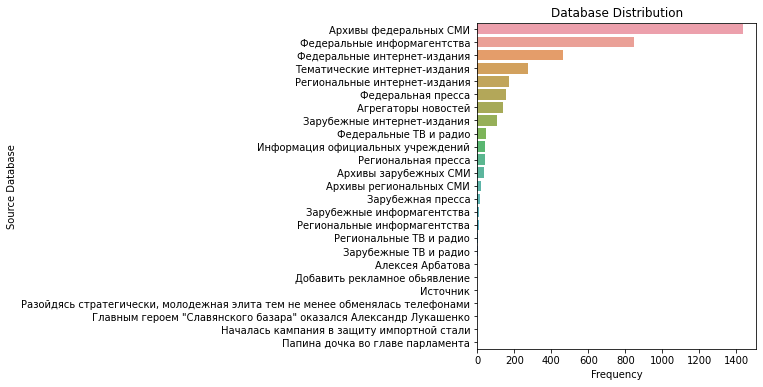

In [27]:
# Let's see how database sources are distributed
x_db = data2.database.value_counts()
y_db = x_db.sort_index()
plt.figure(figsize=(5,6))
sns.barplot(x_db, x_db.index, alpha=0.9)
plt.title("Database Distribution")
plt.xlabel('Frequency')
plt.ylabel('Source Database')
db_list = data2.database.value_counts().reset_index()['index'].tolist()
plt.yticks(np.arange(0, len(db_list), 1), db_list)
plt.show()

In [28]:
# pd.set_option('display.max_rows', None) #viewing all data
# pd.reset_option('display.max_rows')
data2.source.value_counts()


Информационные агентства, часть 3                    426
РИА Новости. Горячая линия-1 (2000 - 10.2006)        295
РИА Новости. Все Новости (архив - 2019)              112
РИА Новости. Международные новости (архив - 2019)    110
РИА Новости. Главное (архив - 2019)                  110
                                                    ... 
Эксперт (PDF-версия)                                   1
Аргументы неделi                                       1
Аргументы неделi (PDF-версия)                          1
Newsvesti.ru                                           1
Зарубежная пресса, часть 2                             1
Name: source, Length: 863, dtype: int64

In [29]:
source_list = data2.source.value_counts()[:20].reset_index()['index'].tolist()
source_list = [re.sub(r'[^\w\s]', '', x) for x in source_list]

In [ ]:
plt.figure(figsize=(30,10))
plt.title('Top 20 Sources', fontsize=20)
data2['source'].value_counts()[:20].plot(kind='pie', labels=source_list,
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle=-5, 
                              textprops={'fontsize': 13})

### Data Cleaning


In [31]:
# As we can see below, "fulltext" contains noisy info. Let's clean it a little bit
data2.fulltext.iloc[0]

'США НЕ ВКЛЮЧИЛИ В ПЕРЕГОВОРЫ РФ ПО СТРАТЕГИЧЕСКОЙ СТАБИЛЬНОСТИ ТЕМУ МИЛИТАРИЗАЦИИ КОСМОСА, МОСКВА ЭТО БУДЕТ УЧИТЫВАТЬ - ЛАВРОВ\nИсточник: РИА Новости. Все Новости\nДата выпуска: 14.10.2020 12:35\nЗаглавие: США НЕ ВКЛЮЧИЛИ В ПЕРЕГОВОРЫ РФ ПО СТРАТЕГИЧЕСКОЙ СТАБИЛЬНОСТИ ТЕМУ МИЛИТАРИЗАЦИИ КОСМОСА, МОСКВА ЭТО БУДЕТ УЧИТЫВАТЬ - ЛАВРОВ\nСША НЕ ВКЛЮЧИЛИ В ПЕРЕГОВОРЫ РФ ПО СТРАТЕГИЧЕСКОЙ СТАБИЛЬНОСТИ ТЕМУ МИЛИТАРИЗАЦИИ КОСМОСА, МОСКВА ЭТО БУДЕТ УЧИТЫВАТЬ - ЛАВРОВ\nРИА НОВОСТИ'

In [32]:
# fulltext contains few different feautures. Let's try to get them
fulltext_topics = ['Источник', 'Дата выпуска', 'Номер выпуска', 'Рубрика']
text_col_names = ['text_source','text_date','text_publ_num','rubric']

In [33]:
# Features have different names, let's replace them with one. Btw, this code could be optimized later:)
data2['fulltext'] = data2['fulltext'].apply(lambda x: x.replace("Issue date", "Дата выпуска") if x.find("Issue date") != -1 else x)
data2['fulltext'] = data2['fulltext'].apply(lambda x: x.replace('_YR', "Дата выпуска") if x.find('_YR') != -1 else x)
data2['fulltext'] = data2['fulltext'].apply(lambda x: x.replace('_TI', 'Заглавие') if x.find('_TI') != -1 else x)
data2['fulltext'] = data2['fulltext'].apply(lambda x: x.replace('Title', 'Заглавие') if x.find('Title') != -1 else x)
data2['fulltext'] = data2['fulltext'].apply(lambda x: x.replace('Source','Источник') if x.find('Source') != -1 else x)


In [122]:
# Now, let's create new columns with features, gotten from fulltext
data2['text'] = data2['fulltext'].apply(lambda x: x[x.find('Заглавие: ') + len('Заглавие: ') :]) # get text from 'fulltext'
for i,j in zip(fulltext_topics, text_col_names):
  data2[j] = data2['fulltext'].apply(lambda x: x[x.find(i) + len(i) + 2 :x.find('\n', x.find(i))]if x.find(i) != -1 else np.nan)
data2.reset_index(drop=True, inplace = True)

In [35]:
data2.info() # view summaries for new data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3839 entries, 0 to 3838
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   name           3839 non-null   object        
 1   fulltext       3839 non-null   object        
 2   database       3839 non-null   object        
 3   source         3839 non-null   object        
 4   date           3839 non-null   object        
 5   full_date      3839 non-null   datetime64[ns]
 6   text           3839 non-null   object        
 7   text_source    3837 non-null   object        
 8   text_date      3837 non-null   object        
 9   text_publ_num  521 non-null    object        
 10  rubric         1069 non-null   object        
dtypes: datetime64[ns](1), object(10)
memory usage: 330.0+ KB


In [140]:
data2['rubric'] = data2.rubric.apply(lambda x: 'other' if type(x) != type('') else re.sub(r'[^\w\s]', ' ', x).lower().strip())

In [125]:
# data2[data2['rubric']== 'other']

### Explore new features

In [141]:
# Let's visualize rubric feature and see what we can get
rubr_list = data2.rubric.value_counts()[:20].reset_index()['index'].tolist()

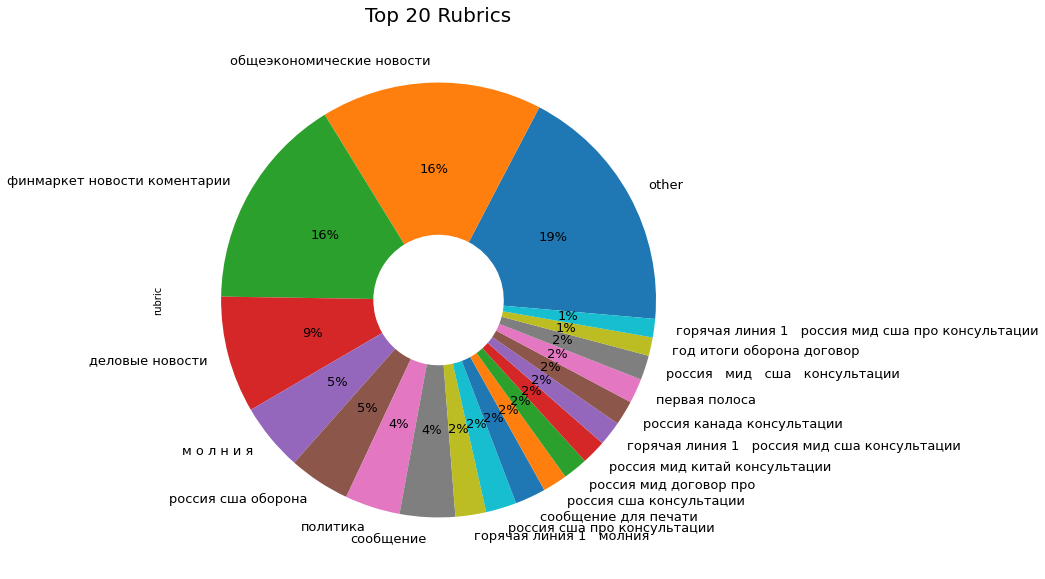

In [142]:
plt.figure(figsize=(30,10))
plt.title('Top 20 Rubrics', fontsize=20)
data2['rubric'].value_counts()[1:21].plot(kind='pie', labels=rubr_list,
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle=-5, 
                              textprops={'fontsize': 13})

In [260]:
df_pos['POS'] = df_pos['POS'].apply(get_pos)
df_pos['POS'].value_counts()

NOUN     1912575
other     882901
VERB      463279
Name: POS, dtype: int64

In [257]:
df_top_pos = df_pos.groupby('POS')['POS'].count().\
    reset_index(name='count').sort_values(['count'],ascending=False)
df_top_pos

,POS,count
55,S,1837651
63,V,463279
14,A=pl,204724
11,A=f,183069
12,A=m,148102
...,...,...
62,S=pl,2
34,INTJ=distort,1
58,S-PRO=m,1
59,S-PRO=n,1


In [ ]:
.plot.bar()

In [249]:
# 15 most used verbs
df_verb = df_pos[df_pos['POS'] == 'V'].copy()
df_verb.groupby('WORD')['WORD'].count().reset_index(name='count').\
    sort_values(['count'], ascending=False).head(15)

,WORD,count
596,будут,4640
6950,заявил,3629
30286,является,3430
9400,могут,3356
26067,сообщает,3203
24997,сказал,3045
14157,отметил,2731
26083,сообщил,2156
17081,подчеркнул,2023
27354,сша,1972


### Preprocessing
To do:
* remove punctuation
* remove stop words
* tokenization with `word_tokenize` from NLTK lib
* stemming with `SnowballStemmer` from NLTK lib
* part-of-speech tagging with `nltk.tag.pos_tag`

In [38]:
punc = string.punctuation

In [39]:
stop_words = set(stopwords.words('russian'))
stop_words.update({'далее','подробнее'})
print(stop_words)

{'далее', 'здесь', 'тоже', 'другой', 'чего', 'какая', 'быть', 'почти', 'этого', 'кто', 'чуть', 'раз', 'и', 'тот', 'через', 'при', 'нет', 'эти', 'свою', 'она', 'чтобы', 'такой', 'уже', 'всего', 'тут', 'два', 'об', 'мне', 'них', 'тем', 'по', 'перед', 'бы', 'разве', 'никогда', 'или', 'между', 'вам', 'ведь', 'себя', 'теперь', 'него', 'от', 'ли', 'им', 'ей', 'ней', 'опять', 'же', 'всю', 'из', 'будет', 'с', 'нее', 'где', 'конечно', 'был', 'его', 'ну', 'потому', 'есть', 'меня', 'там', 'они', 'ничего', 'можно', 'со', 'один', 'хоть', 'много', 'тогда', 'наконец', 'иногда', 'ни', 'без', 'всегда', 'да', 'себе', 'о', 'то', 'эту', 'более', 'впрочем', 'потом', 'ее', 'может', 'после', 'ему', 'что', 'совсем', 'были', 'только', 'во', 'их', 'к', 'еще', 'вдруг', 'ж', 'было', 'хорошо', 'вот', 'для', 'какой', 'а', 'нибудь', 'надо', 'этот', 'не', 'так', 'будто', 'даже', 'до', 'под', 'вы', 'на', 'когда', 'этой', 'куда', 'вас', 'мы', 'нельзя', 'больше', 'три', 'ты', 'ним', 'за', 'я', 'тебя', 'над', 'была', 'на

In [40]:
stemmer = SnowballStemmer("russian") 

In [41]:
data2['tokenized'] = data2['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x)).apply(word_tokenize).apply(lambda x: [word.lower() for word in x if word not in punc and word not in stop_words])
data2['tokenized'] = data2['tokenized'].apply(lambda x:[w for w in x if w not in ['', 'г', 'это', 'которые', 'также'] and w not in stop_words and not w.isnumeric()])


In [42]:
data2['stemmed'] = data2['tokenized'].apply(lambda x: [stemmer.stem(word) for word in x])

In [43]:
data2.stemmed[-5:]

3834    [военнополитическ, стабильн, xxi, век, должн, стро, соблюден, принцип, равн, безопасн, владимир,...
3835    [точк, перехват, противоракетн, оборон, политическ, аргумент, росс, белорусс, последн, врем, дис...
3836    [совещан, президент, м, борис, ельцин, провел, сегодн, совещан, член, совет, безопасн, вопрос, с...
3837    [праздник, ракетчик, москв, ракетн, войск, стратегическ, назначен, вперв, официальн, отмеча, сег...
3838    [вопрос, стратегическ, стабильн, перенацеливан, ядерн, ракет, росс, нанос, ущерб, безопасн, стра...
Name: stemmed, dtype: object

In [44]:
data2['pos_tags'] = data2['tokenized'].apply(nltk.tag.pos_tag, lang = 'rus')

In [ ]:
pos_tags = [w for sublist in data2.pos_tags.tolist() for w in sublist]
df_pos = pd.DataFrame(pos_tags, columns = ['WORD', 'POS'])
df_pos.shape

In [ ]:
def get_pos(tag):
    if tag.startswith('J'):
        return 'ADJ'
    elif tag.startswith('V'):
        return 'VERB'
    elif tag.startswith('N') or tag.startswith('S'):
        return 'NOUN'
    elif tag.startswith('R'):
        return 'ADV'
    else:
        return 'other'

In [45]:
data2['tok_str'] = [' '.join(map(str,l)) for l in data2['tokenized']]
data2['stemm_str'] = [' '.join(map(str,l)) for l in data2['stemmed']]

In [46]:
os.makedirs('ststab/data', exist_ok=True)  
data2.to_csv('ststab/data/data.csv') 

### Visulisations with text data

In [47]:
# Let's count words in each row
data2['word_count'] = data2['stemmed'].apply(lambda x: len(str(x).split()))
data2['word_len'] = data2['stemm_str'].astype(str).apply(len)

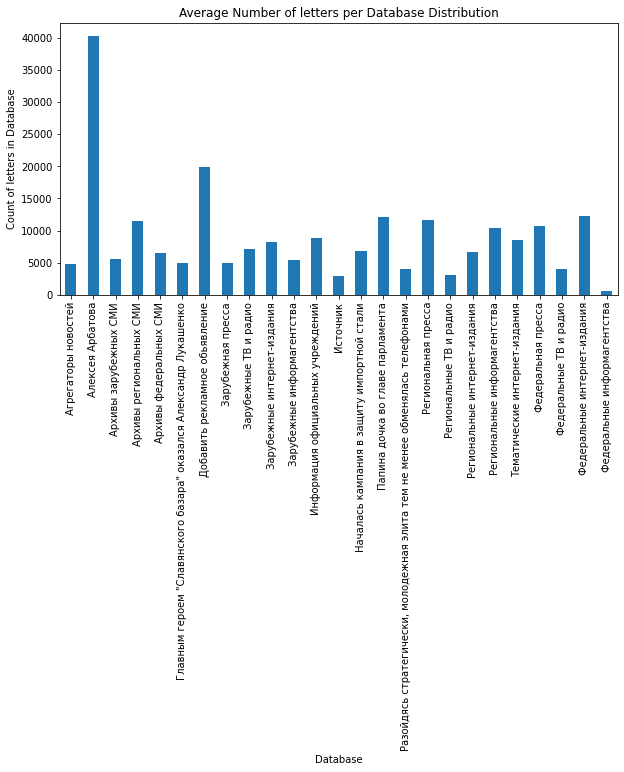

In [48]:
# Now, we can see average length of text depending on its source database
letter_avg = data2.groupby('database')['word_len'].mean().plot(kind='bar', figsize=(10,5))
plt.xlabel('Database')
plt.ylabel('Count of letters in Database')
plt.title('Average Number of letters per Database Distribution')
plt.show()

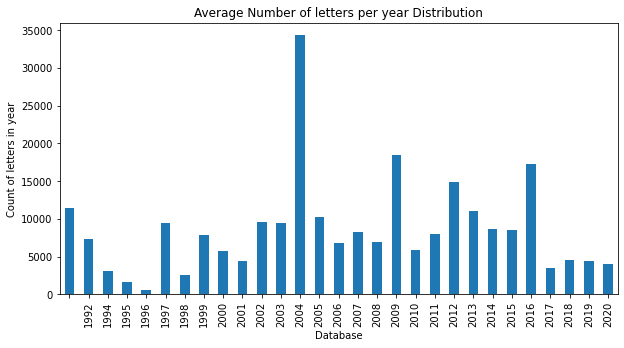

In [49]:
# Let's see, length of text changed depending on year of publishing
letter_avg = data2.groupby('date')['word_len'].mean().plot(kind='bar', figsize=(10,5))
plt.xlabel('Database')
plt.ylabel('Count of letters in year')
plt.title('Average Number of letters per year Distribution')
plt.show()

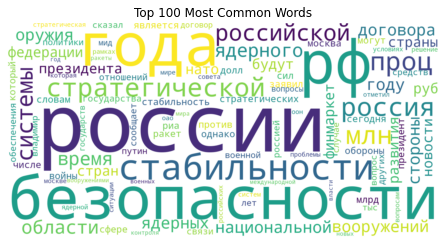

In [50]:
# Now, let's define 100 most common words and show it in wordcloud
allwords = [w for wordlist in data2['tokenized'] for w in wordlist if w not in ['', 'г', 'это', 'которые', 'также'] and w not in stop_words and not w.isnumeric()]
mostcommon = FreqDist(allwords).most_common(100)[1:]
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(' '.join([i[0] for i in mostcommon]))
fig = plt.figure(facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words')
plt.tight_layout(pad=0)
plt.show()

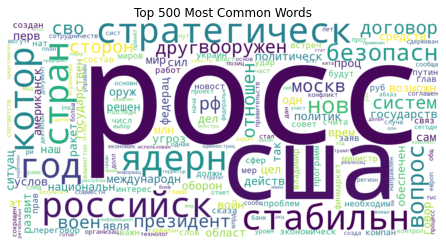

In [51]:
# Let's also see the most common 500 words of stemmed data
allstemmed = [w for wordlist in data2['stemmed'] for w in wordlist]
mostcommon = FreqDist(allstemmed).most_common(500)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(' '.join([i[0] for i in mostcommon]))
fig = plt.figure(facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 500 Most Common Words')
plt.tight_layout(pad=0)
plt.show()

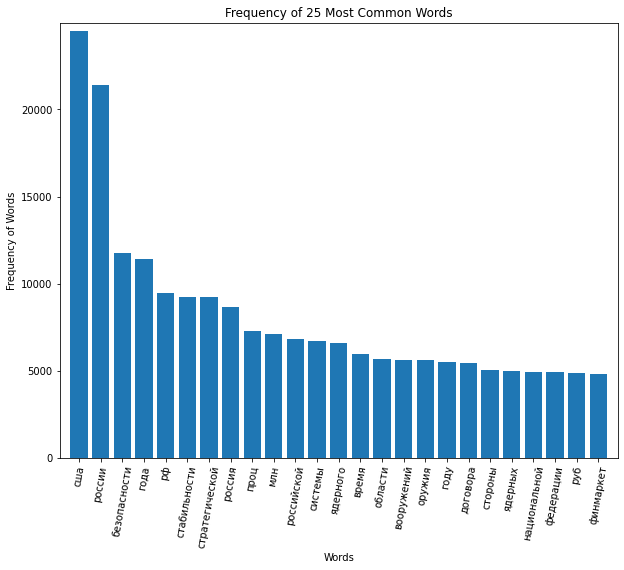

In [52]:
# Let's see frequencies of 25 most common words in text
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(10,8))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.xticks(rotation=80)
plt.title('Frequency of 25 Most Common Words')
plt.show()

# Step 2: Topic Modelling
Определения ключевых тем:
 
* несколько моделей
* вияснить оптимальное количество тем

Результаты работы (3-5 визуализаций):
- ключевые слова по темам
- частота встречания
- расстояние между топиками
- изменение кол-ва упоминаний во времени

### Clustering of data into particular topics
Let's build a few models with [BERTopic](https://github.com/MaartenGr/BERTopic) to explore its possibilities and choose the best amount of topics.


### Models № 1-2: Simple Topic Modeling
Build first two models with tokenized and stemmed text data. Compare their perfomance

In [95]:
vect_text_model = CountVectorizer(ngram_range=(1, 2), stop_words=list(stop_words))

In [58]:
# Tokenized words data
text_model = BERTopic(
    vectorizer_model=vect_text_model,
    language='Russian', calculate_probabilities=True,
    verbose=True
)
text_topics, text_probs = text_model.fit_transform(data2.tok_str.to_list())

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

2022-05-23 22:23:02,398 - BERTopic - Transformed documents to Embeddings
2022-05-23 22:23:36,908 - BERTopic - Reduced dimensionality
2022-05-23 22:23:40,181 - BERTopic - Clustered reduced embeddings


In [60]:
# Stemmed words data
stemmed_text_model = BERTopic(
    vectorizer_model=vect_text_model,
    language='Russian', calculate_probabilities=True,
    verbose=True
)
stemmed_text_topics, stemmed_text_probs = stemmed_text_model.fit_transform(data2.stemm_str.to_list())

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

2022-05-23 22:32:26,578 - BERTopic - Transformed documents to Embeddings
2022-05-23 22:32:55,344 - BERTopic - Reduced dimensionality
2022-05-23 22:32:57,749 - BERTopic - Clustered reduced embeddings


P.S. The top -1 topic shows us the “most generic” of topics


In [67]:
#Let's compare first 15 topics
text_freq = text_model.get_topic_info()
stemmed_text_freq = stemmed_text_model.get_topic_info()
text_freq.set_index('Topic').join(stemmed_text_freq.set_index('Topic'), lsuffix='_tok', rsuffix='_stemm').head(10)

,Count_tok,Name_tok,Count_stemm,Name_stemm
Topic,,,,
-1,1085,-1_сша_россии_безопасности_стратегической,1348.0,-1_росс_сша_год_стратегическ
0,122,0_сша_стратегической стабильности_стабильности_стратегической,231.0,0_ядерн_оруж_сша_стратегическ
1,111,1_украины_затулин_россии_украине,75.0,1_югослав_нат_25мар99_новост
2,74,2_мид_стабильности_стратегической стабильности_иностранных дел,74.0,2_путин_вко_оборон_вопрос
3,68,3_франции_франция_стратегической стабильности_россии франции,72.0,3_вопрос_рф_ссорокин_рпопкович
4,62,4_ядерного_стратегической_стабильности_сша,65.0,4_росс_стабильн_договор_наш
5,48,5_абхазии_хаджимба_фото_абхазам,51.0,5_стратегическ стабильн_стабильн_рф_ри новост
6,46,6_республики абхазия_абхазии_абхазия_республики,48.0,6_национальн_российск федерац_федерац_безопасн
7,44,7_канады_декабря праймтасс_канада_декабря,48.0,7_абхаз_республик абхаз_республик_суд республик


In [210]:
pd.to_pickle(text_model, WORKDIR+"text_model.pkl")
pd.to_pickle(text_topics, WORKDIR+"text_topics.pkl")
pd.to_pickle(text_probs, WORKDIR+"text_probs.pkl")

pd.to_pickle(stemmed_text_model, WORKDIR+"stemmed_text_model.pkl")
pd.to_pickle(stemmed_text_topics, WORKDIR+"stemmed_text_topics.pkl")
pd.to_pickle(stemmed_text_probs, WORKDIR+"stemmed_text_probs.pkl")

In [ ]:
# text_model = pd.read_pickle(WORKDIR+ "text_model.pkl")

### Visualization of results

In [68]:
text_model.visualize_barchart()

In [71]:
stemmed_text_model.visualize_barchart()

In [59]:
# text_model.visualize_hierarchy()
# text_model.visualize_barchart()
# text_model.visualize_topics()



### Model №3: customizing embeddings, dimensionality reduction, clustering and topic extraction

It is important to build high-quality embeddings to make BERTopic work sufficiently.
The Sentence Transformers library provides high-performing sentence embedding models, so let's choose it among other libraries.

`sentence-transformers/all-MiniLM-L6-v2` creates 384-dimensional sentence embeddings.

In [72]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

`Uniform Manifold Approximation and Production` (UMAP)

For each datapoint, UMAP searches through other points and identifies the kth nearest neighbors 

`HDBSCAN` chooses the final clusters based on their size and persistence over varying lambda values. The tree’s thickest, most persistent “branches” are viewed as the most stable and, therefore, best candidates for clusters.

`c-TF-IDF` finds the most relevant terms given all of the “documents” within a cluster.


In [96]:
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.05, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=40, metric='euclidean', gen_min_span_tree=True,
                        cluster_selection_method='eom', prediction_data=True)

In [ ]:
vect_text_model = CountVectorizer(ngram_range=(3, 3), stop_words=list(stop_words))

Params:
* `top_n_words=10` - num of words per topic, the more words are in a topic the less coherent it can become. Ideal value is from 10 to 20, so 10 was chosen
* `n_gram_range=(3,3)` - num of words in topic representation. Trigrams are more informative, than bigrams or unigrams, so value (3, 3) was chosen
* `min_topic_size=10` -  specify what the minimum size of a topic can be, the lower this value the more topics are created. 10 is just right
* `nr_topics` - num of topics that will be reduced to. 10 is just right num of topics for given task
* `calculate_probabilities` - calculates the probabilities of each topic to each document


In [97]:
# based on results of model 1 and 2, let's use tokenized text data and define parameters
top_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vect_text_model,
    min_topic_size=10,
    top_n_words=10,
    language='Russian',
    calculate_probabilities=True,
    verbose=True, nr_topics=10
)
top_topics, top_probs = top_model.fit_transform(data2.tok_str.to_list())

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

2022-05-23 23:58:53,459 - BERTopic - Transformed documents to Embeddings
2022-05-23 23:59:26,972 - BERTopic - Reduced dimensionality
2022-05-23 23:59:27,496 - BERTopic - Clustered reduced embeddings
2022-05-24 00:00:45,522 - BERTopic - Reduced number of topics from 15 to 11


In [98]:
pd.to_pickle(top_model, WORKDIR+"top_model.pkl")
pd.to_pickle(top_topics, WORKDIR+"top_topics.pkl")
pd.to_pickle(top_probs, WORKDIR+"top_probs.pkl")

In [99]:
top_model.get_topic_info()

,Topic,Count,Name
0,0,2035,0_обеспечения национальной безопасности_корр риа новости_вопросам стратегической стабильности_ст...
1,-1,948,-1_москве выступали против_постоянная смена власти_против экстремальных практик_экстремальных пр...
2,1,138,1_вопросы стратегической стабильности_экономика международные отношения_мировая экономика междун...
3,2,137,2_фото анжела кучубериятасс_входят состав россии_пусть входят состав_подобно жириновскому обещал
4,3,124,3_млн тыс руб_рао еэс россии_млрд млн руб_составил млн долл
5,4,112,4_вопросы стратегической стабильности_сфере стратегической стабильности_риа новости лавров_страт...
6,5,95,5_рф стратегической стабильности_стабильности мид рф_стратегической стабильности мид_мид рф риа
7,6,66,6_риа новости путин_вопросам стратегической стабильности_стабильности контроля вооружениями_стра...
8,7,62,7_владимир путин жак_путин жак ширак_противостоять широкому спектру_новый договор снв
9,8,61,8_стабильности риа новости_стратегической стабильности риа_the development of_итартасс защищены ...


In [175]:
top_model.get_topic(0)

[('обеспечения национальной безопасности', 0.003294274905550636),
 ('корр риа новости', 0.0027201023561610645),
 ('вопросам стратегической стабильности', 0.0019095280530167316),
 ('стратегических наступательных вооружений', 0.001887264082681707),
 ('безопасности российской федерации', 0.0018447625806975977),
 ('министра иностранных дел', 0.0014571765130135448),
 ('национальной безопасности сфере', 0.0013937900247137393),
 ('стратегических ядерных сил', 0.001307316933004381),
 ('марта корр риа', 0.0012502612555810384),
 ('министр иностранных дел', 0.0012021919200003808)]

In [178]:
top_model.get_topic(5)

[('рф стратегической стабильности', 0.1100076903305735),
 ('стабильности мид рф', 0.060129024687555335),
 ('стратегической стабильности мид', 0.05921490305410959),
 ('мид рф риа', 0.05912018960494715),
 ('рф риа новости', 0.05701624509979081),
 ('сша рф стратегической', 0.05679522291960677),
 ('рябков риа новости', 0.0541037921835576),
 ('сша стратегической стабильности', 0.05054830341872105),
 ('стратегической стабильности рябков', 0.05006697931022502),
 ('риа новости рф', 0.048092335875123474)]

### Visualization 1: Topic Terms

In [101]:
top_model.visualize_barchart()

### Visualization 2: Topic Distance Map

In [102]:
top_model.visualize_topics()

### Visualization 3: Topic Similarity


In [103]:
top_model.visualize_heatmap()

### Visualization 4: Topic Hierarchy

In [104]:
top_model.visualize_hierarchy()

### Visualization 5: Term Score Decline

In [105]:
top_model.visualize_term_rank()

### Visualization 6: Topics over Time

In [106]:
timestamps = data2.full_date.to_list()
topics_over_time = top_model.topics_over_time(data2.tok_str.to_list(), top_topics, timestamps, nr_bins=20)


20it [09:50, 29.51s/it]


In [107]:
top_model.visualize_topics_over_time(topics_over_time, top_n_topics=6)

### Visualization 7: Visualize Topics per Rubric and Source

In [143]:
classes = data2['rubric'].tolist()

In [144]:
topics_per_class = top_model.topics_per_class(data2.tok_str.to_list(), top_topics, classes=classes)

358it [23:40,  3.97s/it]


KeyboardInterrupt: ignored

In [ ]:
top_model.visualize_topics_per_class(topics_per_class)

In [ ]:
sources = data2['source'].tolist()


In [ ]:
topics_per_source = top_model.topics_per_class(data2.tok_str.to_list(), top_topics, classes=sources)

In [ ]:
top_model.visualize_topics_per_class(topics_per_source)

# Step 3: Building n-grams

Ключевые н-граммы в двух измерениях: 
* для корпуса в целом 
* для каждой темы отдельно

Н-граммы:
* до 5 слов 
* существительные, глаголы, наречия и прилагательные (noun, verb, adverb, adjective)

Визуализия:
* по 20 н-граммов для каждой темы и корпуса
* кол-во слов в н-граммах - выбор
* в зависимости от источника
* изменение списка ключевых н-граммов во времени. 

### N-grams for corpus
Topic modelling with n-grams research [article](https://people.cs.umass.edu/~mccallum/papers/tng-icdm07.pdf)

In [166]:
all_corpus_words = [w for sublist in data2.tokenized.tolist() for w in sublist]

In [197]:
pd.Series(nltk.ngrams(all_corpus_words, 3)).value_counts()[:20]

(обеспечения, национальной, безопасности)       1061
(корр, риа, новости)                            1001
(стратегических, наступательных, вооружений)     822
(вопросам, стратегической, стабильности)         800
(министра, иностранных, дел)                     609
(безопасности, российской, федерации)            580
(вопросы, стратегической, стабильности)          531
(средней, меньшей, дальности)                    522
(министр, иностранных, дел)                      492
(стратегических, ядерных, сил)                   478
(иностранных, дел, россии)                       454
(млн, тыс, руб)                                  406
(национальной, безопасности, сфере)              384
(рао, еэс, россии)                               383
(оружия, массового, уничтожения)                 380
(иностранных, дел, рф)                           363
(марта, корр, риа)                               358
(применения, ядерного, оружия)                   348
(глава, мид, рф)                              

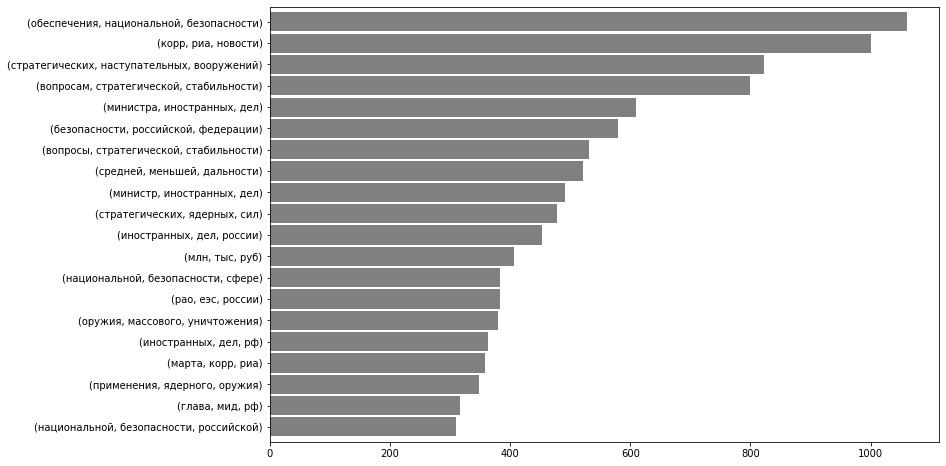

In [196]:
pd.Series(nltk.ngrams(all_corpus_words, 3)).value_counts()[:20].sort_values().plot.barh(color='gray', width=.9, figsize=(12, 8))

### N-grams for topics

In [217]:
# Each topic consists of 10 tri-grams. Let's visualize them
top_model.get_topic(-1)

[('москве выступали против', 0.00288250294313806),
 ('постоянная смена власти', 0.002059607105790166),
 ('против экстремальных практик', 0.0019163937494964729),
 ('экстремальных практик политике', 0.0019163937494964729),
 ('выступали против экстремальных', 0.0019163937494964729),
 ('абхазии москве выступали', 0.0019163937494964729),
 ('политолог алексей чеснаков', 0.0019163937494964729),
 ('чеснаков ситуации абхазии', 0.0019163937494964729),
 ('алексей чеснаков ситуации', 0.0019163937494964729),
 ('ситуации абхазии москве', 0.0019163937494964729)]

In [216]:
get_topic_words = lambda topic_num: [w for sublist in [i[0].split() for i in top_model.get_topic(topic_num)] for w in sublist]

In [215]:
pd.Series(nltk.ngrams(get_topic_words(-1), 3)).value_counts()[:20]

(сша, россии, безопасности, стратегической, стабильности, ядерного, стратегической, стабильности)           1
(россии, безопасности, стратегической, стабильности, ядерного, стратегической, стабильности, россия)        1
(безопасности, стратегической, стабильности, ядерного, стратегической, стабильности, россия, вооружений)    1
(стратегической, стабильности, ядерного, стратегической, стабильности, россия, вооружений, оружия)          1
dtype: int64

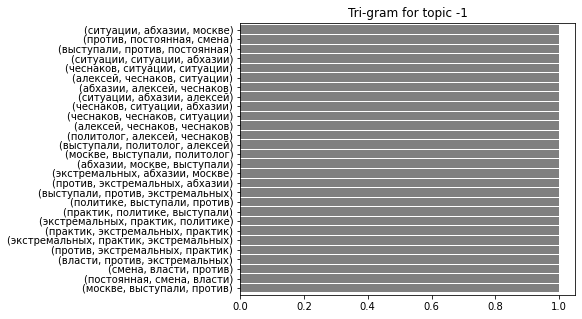

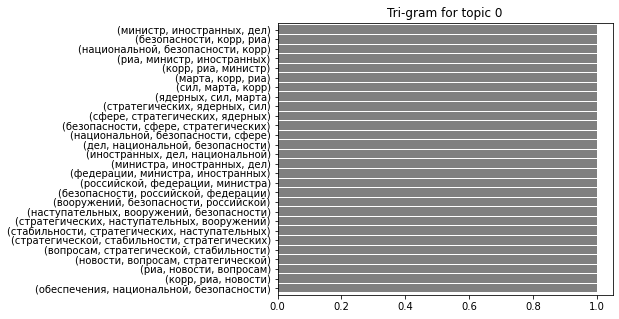

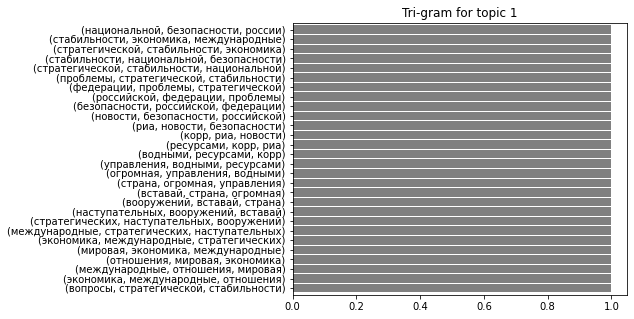

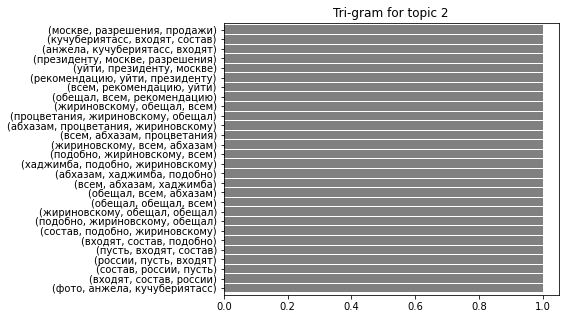

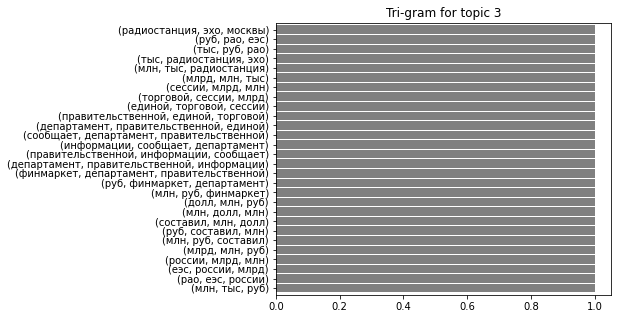

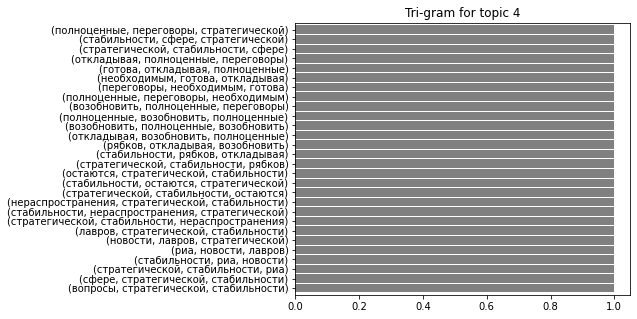

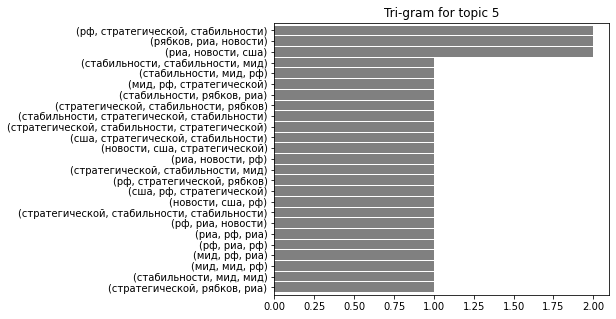

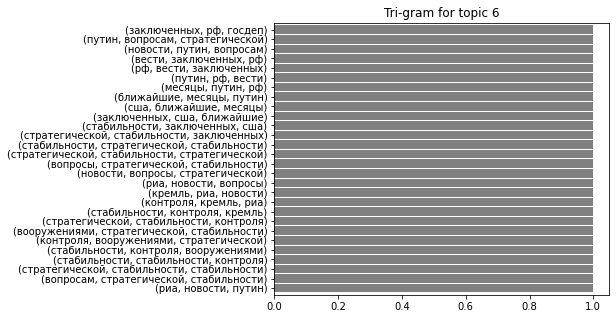

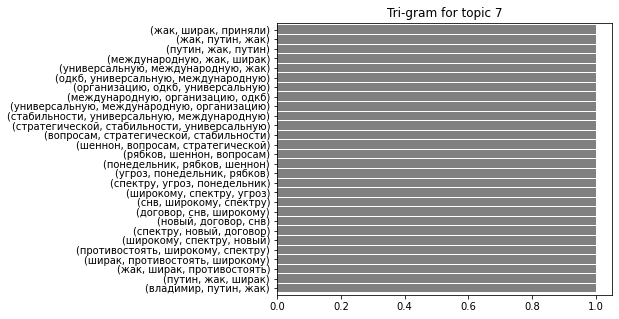

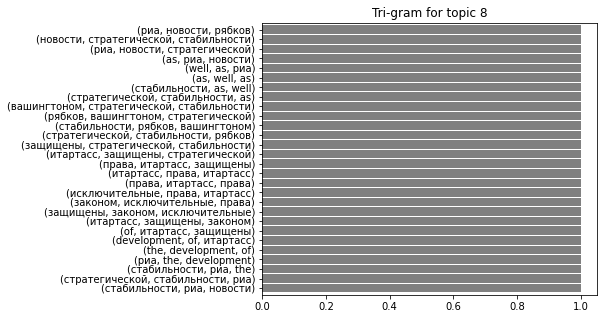

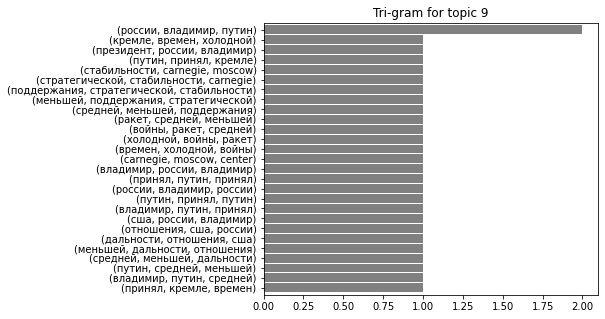

In [227]:
for k in range(-1,10,1):
  pd.Series(nltk.ngrams(get_topic_words(k), 3)).value_counts().sort_values().plot.barh(color='gray', width=.9, figsize=(6, 5), title = 'Tri-gram for topic '+str(k))
  plt.show()

### N-grams for sources

### N-grams for time

# Step 4: Possible Improvements

Как ещё можно глубже понять темы, которые встречаются в корпусе. 

Н-граммы – это только один из вариантов изучения текста. 

Если попалась интересная научная статья на эту тему – прикрепи ссылку на неё.   